# ROC Curve Analysis for Bandpower Ratio
This script is analyzing the bandpower ratio feature by means of ROC curves. For a given frequency bin, roc curve is drawn and optimal threshold is estimated.

The processing is as follows:
1. PCG records are loaded and chunked.
2. Chunks are normalized usng RMS normalization
3. Bandpower ratio of each chunk is calculated
4. Bandpower ratio for different frequency bins is plotted and the optimal one is selected
5. ROC curve is visualized

In [1]:
import numpy as np
import librosa
import librosa.display
from sklearn.ensemble import RandomForestClassifier
from scipy.fftpack import fft
from scipy.signal import welch
from utils import *

**Data Loading and Chunking**

In [3]:
sampling_frequency = 2000 # in Hz
slice_length = 4          # in seconds
overlap = 2               # in seconds

normal_records, normal_records_denoised = load_records(path = '../dataset/normal_tracings.txt',normalize = False, crop = 20000)
abnormal_records, abnormal_records_denoised = load_records(path = '../dataset/abnormal_tracings.txt',normalize = False, crop = 20000)
records_train = np.concatenate((abnormal_records_denoised, normal_records_denoised), axis=0)
labels = np.concatenate((np.ones((abnormal_records_denoised.shape[0],1)),np.zeros((normal_records.shape[0],1))), axis=0)

normal_records_chunks = np.zeros((normal_records_denoised.shape[0], 4, slice_length*sampling_frequency))
slices = np.arange(0, 10, slice_length-overlap, dtype=int)
for i in range(normal_records.shape[0]):
    j = 0
    for start, end in zip(slices[:-1], slices[1:]):
        start_audio = start * sampling_frequency
        end_audio = (end + overlap)* sampling_frequency
        chunk = normal_records_denoised[i, int(start_audio): int(end_audio)]
        normal_records_chunks[i, j, :] = chunk
        j = j + 1  
        
abnormal_records_chunks = np.zeros((abnormal_records_denoised.shape[0], 4, slice_length*sampling_frequency))
for i in range(abnormal_records.shape[0]):
    j = 0
    for start, end in zip(slices[:-1], slices[1:]):
        start_audio = start * sampling_frequency
        end_audio = (end + overlap)* sampling_frequency
        chunk = abnormal_records_denoised[i, int(start_audio): int(end_audio)]
        abnormal_records_chunks[i, j, :] = chunk
        j = j + 1  

abnormal_records_chunks_reshaped = np.reshape(abnormal_records_chunks, (33*4, 8000))
normal_records_chunks_reshaped = np.reshape(normal_records_chunks, (29*4, 8000))
all_records_chunked = np.concatenate((abnormal_records_chunks_reshaped, normal_records_chunks_reshaped), axis = 0)
all_records_chunked_normalized = np.zeros_like(all_records_chunked)
labels_chunked = np.concatenate((np.ones((abnormal_records_chunks_reshaped.shape[0],1)),np.zeros((normal_records_chunks_reshaped.shape[0],1))), axis=0)



**RMS Normalization**

In [ ]:

for i in range(all_records_chunked.shape[0]):
    data = all_records_chunked[i,:]
    rms_level = 0
    r = 10**(rms_level / 10.0)
    a = np.sqrt( (len(data) * r**2) / np.sum(data**2) )
    data = data * a
    all_records_chunked_normalized[i,:] = data


**Bandpower Ratio of Chunks**

In [5]:
hop_length = 5 # in Hz
limit = 1000   # in Hz
window_width = 35 # in Hz
center = window_width/2
bin_starts =[]
bin_ends = []
centers = []
for i in range(int(limit/hop_length)):
    bin_starts.append(center-window_width/2)
    bin_ends.append(center+window_width/2)
    centers.append(center)
    center = center + hop_length
bin_starts = np.array(bin_starts)
bin_ends = np.array(bin_ends)
centers = np.array(centers)

num_windows = int(len(bin_starts))
abnormal_bandpowers = np.zeros((abnormal_records_chunks_reshaped.shape[0],num_windows),dtype='float32')
normal_bandpowers = np.zeros((normal_records_chunks_reshaped.shape[0],num_windows),dtype='float32')
 

**Visualizing bandpower ratio for different frequency bins**

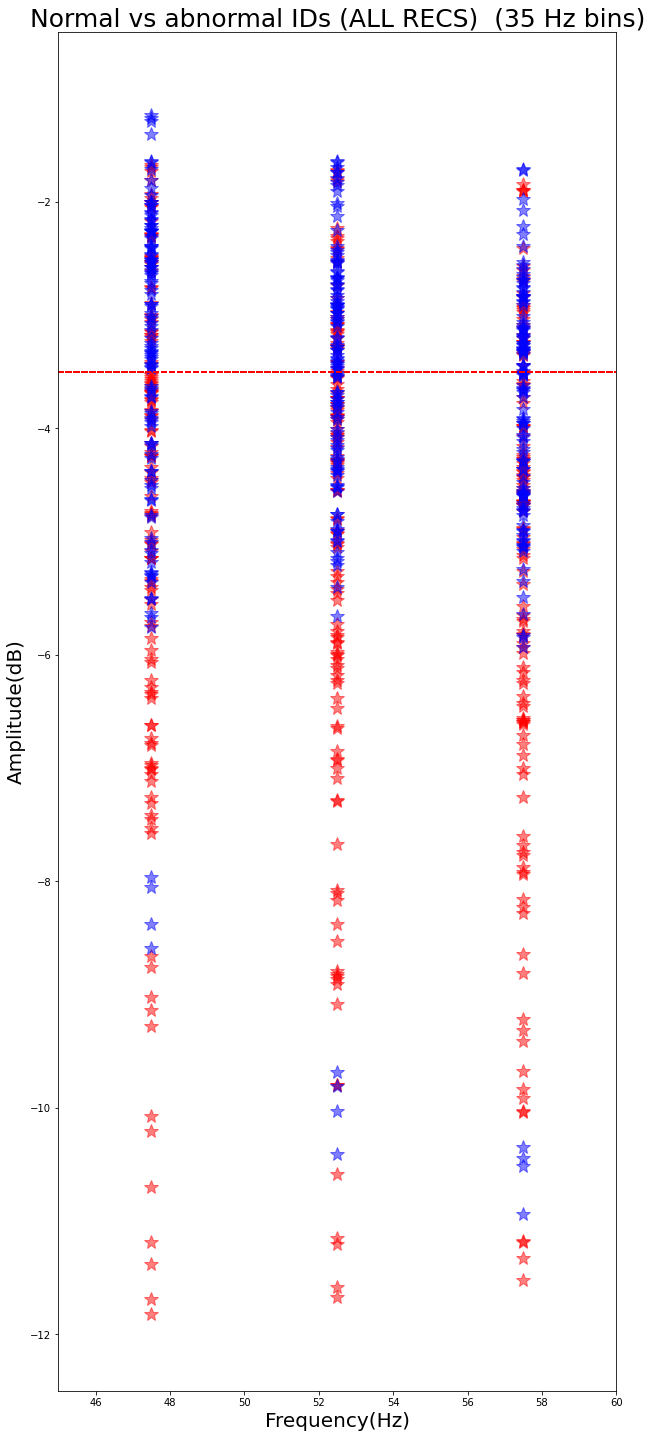

In [13]:
plt.figure(figsize=(10,25))
plt.xlabel("sampling_frequency(Hz)",fontsize = 20)
plt.ylabel("Amplitude(dB)",fontsize = 20)
plt.title("Normal vs abnormal IDs (ALL RECS)  ({} Hz bins)".format(window_width),fontsize = 25)
   
for i in range(0,abnormal_records_chunks_reshaped.shape[0]):  
    f = np.arange(num_windows)
    bp = np.zeros_like(f, dtype=np.float32)
    total_power = bandpower(abnormal_records_chunks_reshaped[i,:],2000,0,1000)
    for j in range(len(f)):
        bp[j] = bandpower(abnormal_records_chunks_reshaped[i,:],2000,bin_starts[j],bin_ends[j])
        abnormal_bandpowers[i,j] = 10*np.log10(bp[j]/total_power)
    plt.plot(centers, abnormal_bandpowers[i,:],'r*',alpha=0.5,markersize=15)

    

for i in range(0,normal_records_chunks_reshaped.shape[0]):  
    f = np.arange(num_windows)
    bp = np.zeros_like(f, dtype=np.float32)
    total_power = bandpower(normal_records_chunks_reshaped[i,:],2000,0,1000)
    for j in range(len(f)):
        bp[j] = bandpower(normal_records_chunks_reshaped[i,:],2000,bin_starts[j],bin_ends[j])
        normal_bandpowers[i,j] = 10*np.log10(bp[j]/total_power)
    plt.plot(centers, normal_bandpowers[i,:],'b*',alpha=0.5,markersize=15)
    plt.ylim(-12.5,-0.5)
    plt.xlim(45,60)
    plt.axhline(y=-3.5, color='r', linestyle='--',alpha=0.5)

**ROC curve visualization**

Optimal threshold: -3.778894472361813
Optimal sensitivity and specificity: 0.67, 0.36
Frequency bin center: 52.5Hz


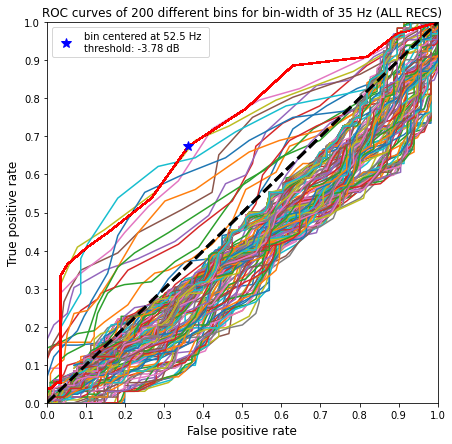

In [34]:
threshold = np.linspace(-80,-1,200)
threshold = np.double(threshold)

true_positives = np.zeros((len(threshold),abnormal_bandpowers.shape[1]))
false_positives = np.zeros((len(threshold),abnormal_bandpowers.shape[1]))
false_negatives = np.zeros((len(threshold),abnormal_bandpowers.shape[1]))
true_negatives = np.zeros((len(threshold),abnormal_bandpowers.shape[1]))
true_positive_rate = np.zeros((len(threshold),abnormal_bandpowers.shape[1]),dtype=np.float32)
false_positive_rate = np.zeros((len(threshold),abnormal_bandpowers.shape[1]),dtype=np.float32)

for t in range(len(threshold)):
    for i in range(abnormal_bandpowers.shape[1]):
        true_positives[t,i] = (abnormal_bandpowers[:,i] <= threshold[t]).sum()
        false_positives[t,i] = (normal_bandpowers[:,i] <= threshold[t]).sum()
        false_negatives[t,i] = (abnormal_bandpowers[:,i] >= threshold[t]).sum()
        true_negatives[t,i] = (normal_bandpowers[:,i] >= threshold[t]).sum()
        true_positive_rate[t,i] = true_positives[t,i] / (true_positives[t,i] + false_negatives[t,i])
        false_positive_rate[t,i] = false_positives[t,i] / (false_positives[t,i] + true_negatives[t,i])

a=int(limit/hop_length)
plt.figure(figsize=(7,7))
plt.ylabel('True positive rate',fontsize = 12)
plt.xlabel('False positive rate',fontsize = 12)
plt.title('ROC curves of {} different bins for bin-width of {} Hz (ALL RECS)'.format(a,window_width), fontsize=12)
diag_x= np.linspace(0,1,10)
diag_y= np.linspace(0,1,10)
plt.plot(diag_x,diag_y,'k--', linewidth=3.0)
plt.xlim(0,1)
plt.ylim(0,1)
plt.locator_params(axis="x", nbins=10)
plt.locator_params(axis="y", nbins=10)

index = 7
for i in range (0,200):
    plt.plot(false_positive_rate[:,i],true_positive_rate[:,i])
    plt.plot(false_positive_rate[:,index],true_positive_rate[:,index],'r')

plt.plot(diag_x,diag_y,'k--', linewidth=3.0)
plt.xlim(0,1)
plt.ylim(0,1)
plt.locator_params(axis="x", nbins=10)
plt.locator_params(axis="y", nbins=10)


best_window_index=7 # manually selected
best_th_index=192   # manually selected
optimal_specificity = "%.2f" % false_positive_rate[best_th_index,best_window_index]
optimal_sensitivity = "%.2f" % true_positive_rate[best_th_index,best_window_index]
print(f"Optimal threshold: {threshold[best_th_index]}")
print(f"Optimal sensitivity and specificity: {optimal_sensitivity}, {optimal_specificity}")
print(f"sampling_frequency bin center: {centers[best_window_index]} Hz")


threshold[best_th_index] = float("{:.2f}".format(threshold[best_th_index]))
plt.plot(false_positive_rate[best_th_index,best_window_index],true_positive_rate[best_th_index,best_window_index],'b*',label='bin centered at {} Hz \nthreshold: {} dB'.format(centers[best_window_index],threshold[best_th_index]), markersize = 10)
figname = "roc_curve.png"
plt.savefig(figname,dpi=100)
plt.legend(loc='best') 
plt.show()


